# 経費申請分析 (Expense Claim Analysis)

このノートブックは英語版 `10-expense_claim-demo.ipynb` と同等です。領収書画像を読み取り、構造化データへ変換し、経費申請メール案を生成する流れをマルチエージェントで示します。

手順:
1. OCR エージェントがローカル領収書画像から旅費関連の経費明細 (日付 / 内容 / 金額 / 分類) を抽出します。
2. メールエージェントが抽出結果を受け取り経費申請メール本文を生成します。

### 想定する出張経費シナリオ例
あなたが別都市での打ち合わせに出張した社員であるとします。会社は出張に関連する合理的な費用を精算対象としています。代表的な費用例は次のとおりです。
- 交通費: 往復航空券 / 空港との移動 (タクシー等) / 現地移動 (公共交通・レンタカー等)
- 宿泊費: 会場近くのビジネスホテル (複数泊)
- 食事: 会社規定の日当や実費精算対象の朝食・昼食・夕食
- 雑費: 空港駐車料金 / ホテルのインターネット利用料 / チップや小額サービス料
- 提出書類: 各領収書 (フライト・移動・宿泊・食事など) と明細レポート

これらをもとに、OCR 抽出 → 構造化 → メール生成 という最小構成を学びます。

## ライブラリ読込
必要なライブラリを読み込みます。

In [1]:
import os
from dotenv import load_dotenv
from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from semantic_kernel.kernel import Kernel
from semantic_kernel.agents import AgentGroupChat
from openai import AsyncOpenAI
from semantic_kernel.agents import ChatCompletionAgent, AgentGroupChat
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.agents.strategies import SequentialSelectionStrategy, DefaultTerminationStrategy
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents import ImageContent, TextContent
from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion, OpenAIChatPromptExecutionSettings
from semantic_kernel.functions import kernel_function, KernelArguments
from pydantic import BaseModel, Field
from typing import List
from azure.ai.inference.models import SystemMessage, UserMessage, TextContentItem, ImageContentItem, ImageUrl, ImageDetailLevel
load_dotenv()

True

receipt.jpg: 存在します
ファイルサイズ: 261773 bytes
画像寸法: (1536, 1225)


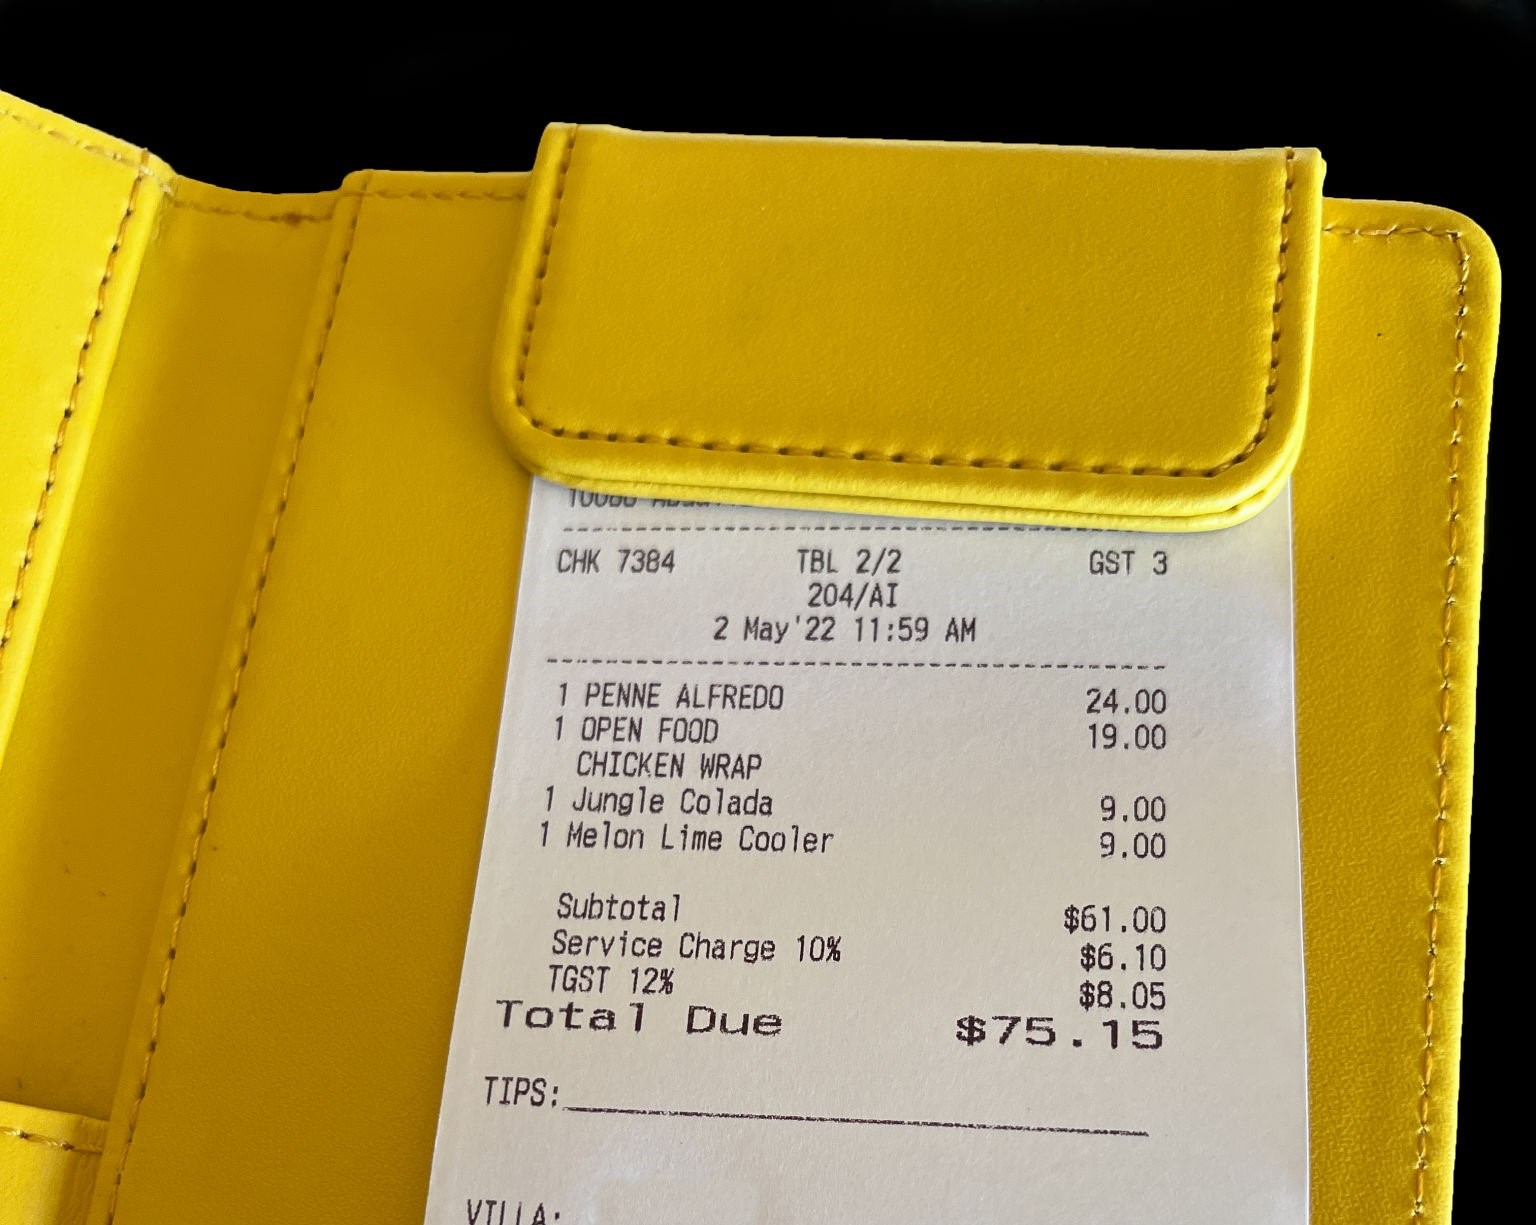

In [2]:
# receipt.jpg の存在確認と基本情報表示
from pathlib import Path
try:
    p = Path('receipt.jpg')
    if p.exists():
        print('receipt.jpg: 存在します')
        print('ファイルサイズ:', p.stat().st_size, 'bytes')
        try:
            from PIL import Image
            with Image.open(p) as im:
                print('画像寸法:', im.size)
                display(im)
        except Exception as e:
            print('画像読み込み時の警告:', e)
    else:
        print('receipt.jpg: 見つかりません。英語版フォルダからコピーしてください。')
except Exception as e:
    print('確認処理でエラー:', e)

In [3]:
def _create_kernel_with_chat_completion(service_id: str) -> Kernel:
    kernel = Kernel()
    client = AsyncOpenAI(api_key=os.environ['GITHUB_TOKEN'], base_url='https://models.inference.ai.azure.com/')
    kernel.add_service(OpenAIChatCompletion(ai_model_id='gpt-4o-mini', async_client=client, service_id='open_ai'))
    kernel.add_service(OpenAIChatCompletion(ai_model_id='gpt-4o', async_client=client, service_id='gpt-4o'))
    return kernel

## 経費モデル定義
個々の経費アイテムを表す Pydantic モデルと、生テキスト (date|description|amount|category をセミコロンで連結) を構造化配列へ変換するフォーマッタです。

各経費要素例:
`{"date": "07-Mar-2025", "description": "flight to destination", "amount": 675.99, "category": "Transportation"}`

抽出後はメール生成エージェントに渡して再フォーマットしやすい形になります。

In [4]:
class Expense(BaseModel):
    date: str = Field(..., description='日付 (dd-MMM-yyyy)')
    description: str = Field(..., description='説明')
    amount: float = Field(..., description='金額')
    category: str = Field(..., description='分類 (Transportation, Meals, Accommodation, Miscellaneous)')

class ExpenseFormatter(BaseModel):
    raw_query: str = Field(..., description='経費詳細を含む生文字列')
    def parse_expenses(self) -> List[Expense]:
        expense_list = []
        for expense_str in self.raw_query.split(';'):
            if expense_str.strip():
                parts = expense_str.strip().split('|')
                if len(parts) == 4:
                    date, description, amount, category = parts
                    try:
                        expense = Expense(date=date.strip(), description=description.strip(), amount=float(amount.strip()), category=category.strip())
                        expense_list.append(expense)
                    except ValueError as e:
                        print(f'[LOG] Parse Error: {e}')
        return expense_list

## メール生成エージェント
抽出済み経費データを受け取り、経費申請メール本文を生成します。
- `kernel_function` デコレータで関数をプラグイン公開します。
- 合計金額を計算し、箇条書きで内訳を整形します。
- 余分な説明を避け簡潔な申請文を出力します。

In [5]:
class ExpenseEmailAgent:
    """経費申請メール本文を生成するエージェントです。
    - 合計金額を計算します。
    - 各項目を箇条書き形式で整形します。
    - 読み手がすぐ確認できる簡潔な敬体文にします。
    - 先頭に [EMAIL_OUTPUT] タグを付与し後段で安定検出できるようにします。
    """

    @kernel_function(description='経費申請メール本文を生成します')
    async def generate_expense_email(expenses):
        total_amount = sum(expense['amount'] for expense in expenses)
        body_lines = []
        body_lines.append('[EMAIL_OUTPUT]')  # 検出用タグ (教材目的)
        body_lines.append('財務チーム各位')
        body_lines.append('')
        body_lines.append('以下が今回の経費申請の内訳です。')
        body_lines.append('')
        for expense in expenses:
            body_lines.append(f"- {expense['description']}: ${expense['amount']}")
        body_lines.append('')
        body_lines.append(f"合計金額: ${total_amount}")
        body_lines.append('')
        body_lines.append('領収書を添付していますのでご確認ください。')
        body_lines.append('')
        body_lines.append('よろしくお願いいたします。')
        body_lines.append('[氏名]')  # 必要に応じて差し替えてください。
        return '\n'.join(body_lines)

In [6]:
class OCRAgentPlugin:
    """領収書画像から旅費関連の構造化データを抽出する簡易OCRプラグインです。
    - gpt-4o マルチモーダル機能で画像+指示を処理します。
    - 日付|説明|金額|分類 をセミコロン区切りで返します。
    - 分類は Transportation / Accommodation / Meals / Miscellaneous から推定します。
    失敗時はログ文を返します。"""

    def __init__(self):
        self.client = ChatCompletionsClient(
            endpoint='https://models.inference.ai.azure.com/',
            credential=AzureKeyCredential(os.environ.get('GITHUB_TOKEN')),
        )
        self.model_name = 'gpt-4o'

    @kernel_function(description='receipt.jpg から旅費経費データを抽出します')
    def extract_text(self, image_path: str = 'receipt.jpg') -> str:
        try:
            from pathlib import Path
            p = Path(image_path)
            if not p.exists():
                return f"[LOG] OCR Plugin: 画像 {image_path} が存在しません。"
            image_url_str = str(ImageUrl.load(image_file=image_path, image_format='jpg', detail=ImageDetailLevel.HIGH))
            prompt = (
                'あなたは領収書画像から旅費関連の明細を抽出する支援エージェントです。'
                '以下形式で返してください: date|description|amount|category をセミコロン区切りで羅列します。'
                '日付は dd-MMM-yyyy 形式に統一してください。金額は数値のみです。'
                'category は Transportation / Meals / Accommodation / Meals / Miscellaneous のいずれかです。'
                '合計欄や税額など個別明細でない行は除外してください。'
                '該当しない場合は No expenses detected としてください。'
                '追加の説明文や自然文は出力しないでください。'
            )
            response = self.client.complete(
                messages=[
                    SystemMessage(content=prompt),
                    UserMessage(content=[
                        TextContentItem(text='Extract travel expenses from this receipt image.'),
                        ImageContentItem(image_url=ImageUrl(url=image_url_str))
                    ])
                ],
                model=self.model_name,
                temperature=0.1,
                max_tokens=2048
            )
            extracted_text = response.choices[0].message.content
            return extracted_text
        except Exception as e:
            error_msg = f"[LOG] OCR Plugin: Error processing image: {str(e)}"
            print(error_msg)
            return error_msg

## OCR 抽出エージェント
領収書画像を gpt-4o マルチモーダル推論に渡し、旅費関連の明細を構造化文字列として抽出します。
- 画像 + 指示メッセージを送信します。
- モデル応答をそのままパース対象文字列として後工程へ渡します。
- 失敗時はログ文を返し、後続処理が検出しやすくします。

In [7]:
async def process_expenses():
    """経費データ処理メインフローです。
    1. OCR エージェントが画像から構造化テキストを抽出します。
    2. メールエージェントが抽出結果を元に申請メール案を生成します。
    3. グループチャットを逐次選択戦略で 1 回実行します。
    戻り値: 生成順のメッセージ文字列リストです。
    """
    load_dotenv()

    from pathlib import Path
    image_path = Path('./receipt.jpg')
    if not image_path.exists():
        print('[WARN] receipt.jpg が見つかりません。抽出ステップはスキップされる可能性があります。')

    settings_slm = OpenAIChatPromptExecutionSettings(service_id='gpt-4o')
    settings_llm = OpenAIChatPromptExecutionSettings(service_id='open_ai')

    ocr_agent = ChatCompletionAgent(
        kernel=_create_kernel_with_chat_completion('ocrAgent'),
        name='ocr_agent',
        instructions=(
            "領収書画像から 'extract_text' 関数 (ocrAgent プラグイン) を使って date|description|amount|category を抽出してください。"
            "項目はセミコロンで連結し、余分な説明文を付加しないでください。"
        ),
        arguments=KernelArguments(settings=settings_slm)
    )

    email_agent = ChatCompletionAgent(
        kernel=_create_kernel_with_chat_completion('expenseEmailAgent'),
        name='email_agent',
        instructions=(
            "直前エージェントの出力 (抽出済み経費) を読み取り 'generate_expense_email' 関数で経費申請メール本文を作成してください。"
            "原文項目を改変しないでください。"
        ),
        arguments=KernelArguments(settings=settings_llm)
    )

    kernel = Kernel()
    user_message = ChatMessageContent(
        role=AuthorRole.USER,
        items=[
            TextContent(text='領収書画像から旅費関連の明細を抽出し、続けて経費申請メール案を生成してください。'),
            ImageContent.from_image_file(path=str(image_path)) if image_path.exists() else TextContent(text='(画像未検出)')
        ]
    )

    kernel.add_plugin(OCRAgentPlugin(), plugin_name='ocrAgent')
    kernel.add_plugin(ExpenseEmailAgent(), plugin_name='expenseEmailAgent')

    chat = AgentGroupChat(
        agents=[ocr_agent, email_agent],
        selection_strategy=SequentialSelectionStrategy(initial_agent=ocr_agent),
        termination_strategy=DefaultTerminationStrategy(maximum_iterations=1)
    )

    await chat.add_chat_message(user_message)
    print('# ユーザーメッセージを追加しました (画像 + 指示)')

    collected = []
    async for content in chat.invoke():
        text = content.content
        collected.append(text)
        print(f"# Agent - {content.name or '*'}: {text}")

    return collected

## 処理フロー (process_expenses)
- 環境変数読込後に 2 種類の ChatCompletionAgent を作成します。
- SequentialSelectionStrategy で OCR → メールの順番を固定します。
- 1 イテレーション (最大) で完了させ冗長対話を避けます。
- 画像 + 指示を最初のユーザーメッセージとして投入します。
- ストリーミング出力を逐次表示し経緯を把握しやすくします。

In [8]:
async def main():
    # 画面クリア (任意)
    os.system('cls' if os.name=='nt' else 'clear')
    messages = await process_expenses()
    # 最終メッセージ(メール本文)を返します。
    return messages

messages = await main()
print('\n# --- 取得メッセージ件数:', len(messages))

# ユーザーメッセージを追加しました (画像 + 指示)
# Agent - ocr_agent: date: 2 May '22; description: Penne Alfredo; amount: 24.00; category: Meal  
date: 2 May '22; description: Chicken Wrap; amount: 19.00; category: Meal  
date: 2 May '22; description: Jungle Colada; amount: 9.00; category: Beverage  
date: 2 May '22; description: Melon Lime Cooler; amount: 9.00; category: Beverage  

---

**経費申請メール案:**

件名: 経費申請 - 食事代

本文:  
経理部 御中  

お疲れ様です。以下の通り、旅費関連経費の申請をさせていただきます。添付の領収書をご確認ください。  

- 日付: 2022年5月2日  
  内容:  
  - Penne Alfredo - $24.00  
  - Chicken Wrap - $19.00  
  - Jungle Colada - $9.00  
  - Melon Lime Cooler - $9.00  

合計金額: $75.15  

ご確認のほどよろしくお願い申し上げます。  
  
[氏名]  
[連絡先]  

# --- 取得メッセージ件数: 1
# Agent - ocr_agent: date: 2 May '22; description: Penne Alfredo; amount: 24.00; category: Meal  
date: 2 May '22; description: Chicken Wrap; amount: 19.00; category: Meal  
date: 2 May '22; description: Jungle Colada; amount: 9.00; category: Beverage  
date: 2 May '22; description: Melon Lime Cooler; amou

## メイン実行
`process_expenses` を実行して OCR 抽出からメール生成まで 1 回の対話で完了させます。

### メール本文タグ抽出について
学習目的で最終成果物を安定取得するため、メール本文先頭に `[EMAIL_OUTPUT]` タグを付与しています。解析セルでは:
- 最初に出現した `[EMAIL_OUTPUT]` をメール本文として採用します。
- 経費明細文字列 ( `|` と `;` を含む ) を並行して検出し構造化します。
- タグは表示時に取り除き、読みやすさを保ちます。

In [9]:
# 抽出結果解析 + メール本文表示 (タグ方式)
# 教材注釈:
# - [EMAIL_OUTPUT] タグが無くても LLM 出力が明確なメール本文形式なら学習目的では問題ありません。
# - 実運用ではタグや構造化(JSON)で境界を機械的に特定し、誤送信や部分抜けを防ぐことが重要です。
# - タグ未検出は「検出ロジック改善」または「エージェント出力フォーマット調整」の判断材料になります。

from collections import defaultdict
import json

raw_expense_line = None
email_text = None

for m in messages:
    if m:
        if '[EMAIL_OUTPUT]' in m and email_text is None:
            email_text = m
        if ('|' in m and ';' in m) and raw_expense_line is None:
            raw_expense_line = m
    if raw_expense_line and email_text:
        break

# 経費構造化表示
if raw_expense_line is None:
    print('経費抽出文字列が見つかりませんでした。')
else:
    formatter = ExpenseFormatter(raw_query=raw_expense_line)
    expenses = formatter.parse_expenses()
    print(f'# 構造化件数: {len(expenses)}')
    total_per_category = defaultdict(float)
    for e in expenses:
        total_per_category[e.category] += e.amount
    for cat, val in total_per_category.items():
        print(f'- {cat}: ${val:.2f}')

    # 可視化
    try:
        import matplotlib.pyplot as plt
        labels = list(total_per_category.keys())
        sizes = [total_per_category[k] for k in labels]
        if sizes:
            fig, ax = plt.subplots()
            ax.pie(sizes, labels=labels, autopct='%1.1f%%')
            ax.set_title('カテゴリ別金額割合')
            plt.show()
    except Exception as e:
        print(f'可視化でエラー: {e}')

print('\n# --- 経費申請メール本文 ---')
if email_text:
    cleaned = '\n'.join([line for line in email_text.split('\n') if line.strip() and line.strip() != '[EMAIL_OUTPUT]'])
    print(cleaned)
else:
    print('タグ未検出です。出力一覧からメール本文らしい部分を上で確認してください。')

経費抽出文字列が見つかりませんでした。

# --- 経費申請メール本文 ---
メール本文が検出できませんでした (タグ [EMAIL_OUTPUT] 未出現)。
